In [ ]:
!pip install optuna --quiet

In [ ]:
!pip install optuna-integration --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from optuna.integration import TFKerasPruningCallback

In [ ]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

In [ ]:
# Load data
df_original= pd.read_excel('Total.xlsx')
print(df_original.head())


        Date  Max Temperature  Min Temperature  Precipitation      Wind  \
0 1981-03-21           32.129           15.476       0.000000  2.323745   
1 1981-03-22           30.684           19.719       0.607683  2.686932   
2 1981-03-23           32.564           19.376       4.067518  2.694658   
3 1981-03-24           33.151           23.626       0.000000  5.599542   
4 1981-03-25           30.615           24.187       0.000000  3.765550   

   Relative Humidity      Solar  tabkhir  debi  
0           0.324832  22.450215      2.9  86.0  
1           0.379659  21.654897      2.6  75.6  
2           0.417122  19.871775      2.2  70.0  
3           0.227993  15.473473      2.3  64.4  
4           0.280895   9.735983      1.1  69.2  


In [ ]:
# Handle missing values
df_original['debi'] = df_original['debi'].fillna(df_original['debi'].mean())
df_original['tabkhir'] = df_original['tabkhir'].fillna(df_original['tabkhir'].mean())

# Convert 'Date' column to datetime and set as index
df_original.index = pd.to_datetime(df_original['Date'], format='%d.%m.%Y %H:%M:%S')
df_original = df_original.drop(columns=['Date'])  # Drop the original 'Date' column

df=df_original.copy()

In [ ]:
print(df.head())

            Max Temperature  Min Temperature  Precipitation      Wind  \
Date                                                                    
1981-03-21           32.129           15.476       0.000000  2.323745   
1981-03-22           30.684           19.719       0.607683  2.686932   
1981-03-23           32.564           19.376       4.067518  2.694658   
1981-03-24           33.151           23.626       0.000000  5.599542   
1981-03-25           30.615           24.187       0.000000  3.765550   

            Relative Humidity      Solar  tabkhir  debi  
Date                                                     
1981-03-21           0.324832  22.450215      2.9  86.0  
1981-03-22           0.379659  21.654897      2.6  75.6  
1981-03-23           0.417122  19.871775      2.2  70.0  
1981-03-24           0.227993  15.473473      2.3  64.4  
1981-03-25           0.280895   9.735983      1.1  69.2  


In [ ]:
# Feature Engineering
def create_lag_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

def create_rolling_features(df, target_col, window_sizes):
    for window in window_sizes:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    return df.dropna()

def create_temporal_features(df):
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['season'] = (df.index.month % 12 + 3) // 3  # 1: Winter, 2: Spring, 3: Summer, 4: Fall
    return df

def create_domain_features(df):
    df['cumulative_precipitation'] = df['Precipitation'].cumsum()
    df['temperature_anomaly'] = df['Max Temperature'] - df['Max Temperature'].rolling(window=30).mean()
    return df

In [ ]:
# Apply feature engineering
# df = create_lag_features(df, 'debi', lags=[1, 2, 3, 7, 14])
# df = create_rolling_features(df, 'debi', window_sizes=[3, 7, 14])
# df = create_temporal_features(df)
# df = create_domain_features(df)
# df = df.dropna()

In [ ]:
# Normalize data
for col in df.columns:
    df[col] = df[col] / df[col].max()


In [ ]:
print(df.head())

            Max Temperature  Min Temperature  Precipitation      Wind  \
Date                                                                    
1981-03-21         0.635199         0.418950       0.000000  0.255033   
1981-03-22         0.606631         0.533812       0.007118  0.294893   
1981-03-23         0.643799         0.524526       0.047643  0.295741   
1981-03-24         0.655404         0.639578       0.000000  0.614554   
1981-03-25         0.605267         0.654764       0.000000  0.413272   

            Relative Humidity     Solar   tabkhir      debi  
Date                                                         
1981-03-21           0.356202  0.712268  0.150259  0.076992  
1981-03-22           0.416324  0.687035  0.134715  0.067681  
1981-03-23           0.457405  0.630463  0.113990  0.062668  
1981-03-24           0.250011  0.490920  0.119171  0.057654  
1981-03-25           0.308022  0.308889  0.056995  0.061952  


In [ ]:
# Split into features and target
X = df.drop(columns=['debi'])
y = df['debi']

In [ ]:
# Create sequences for LSTM
def df_to_X_y(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][-1]  # Assuming 'debi' is the last column
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
# Aplly sequencing for LSTM
window_size = 30
X1, y1 = df_to_X_y(df, window_size)

In [ ]:
# Split into training, validation, and test sets
train_size = int(0.8 * X1.shape[0])
val_size = int(0.10 * X1.shape[0])
test_size = X1.shape[0] - train_size - val_size

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size + val_size], y1[train_size:train_size + val_size]
X_test1, y_test1 = X1[train_size + val_size:], y1[train_size + val_size:]

In [ ]:
# Define Optuna multi-processed approach for hyper parameter tuning:
# The model is tailored with LSTM
def objective(trial):
    # Define hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 64, 256,step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5,step=0.1)
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)
    dense_units = trial.suggest_int('dense_units', 64, 256,step=64)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build the model
    model = Sequential()
    model.add(InputLayer((X_train1.shape[1], X_train1.shape[2])))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(rate=dropout_rate))

    for _ in range(num_dense_layers):
        model.add(Dense(units=dense_units, activation='relu'))

    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])

    # Train the model
    history = model.fit(
        X_train1, y_train1,
        validation_data=(X_val1, y_val1),
        epochs=100,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            TFKerasPruningCallback(trial, 'val_loss')
        ],
        verbose=0  # Suppresses training logs for better performance
    )

    # Save the model after training (for later use)
    model.save(f"best_model_trial_{trial.number}.keras")

    # Return both the best validation loss and the entire history, as well as
    trial.set_user_attr("history", history.history)
    return min(history.history['val_loss'])

In [ ]:
import multiprocessing
print("CPU Cores Available:", multiprocessing.cpu_count())

CPU Cores Available: 2


In [ ]:
#import tensorflow as tf
#tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
from optuna.samplers import TPESampler

In [ ]:
# Create an Optuna study
study = optuna.create_study(
    direction='minimize',  # Minimize validation loss
    sampler=TPESampler(),  # Use TPE (Tree-structured Parzen Estimator) for efficient sampling
    pruner=optuna.pruners.MedianPruner()  # Prune unpromising trials
)

#study.optimize(objective, n_trials=10, n_jobs=-1)  # Use all available cores n_jobs=-1 (for using multicpu)
study.optimize(objective, n_trials=200, n_jobs=-1)  # Use all available cores n_jobs=1 (for using GPU)

[I 2025-02-19 12:58:53,304] A new study created in memory with name: no-name-bf78e5e9-88a2-4a13-9e54-cc3ab98bab35
[I 2025-02-19 13:03:15,666] Trial 0 finished with value: 0.0018284644465893507 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'num_dense_layers': 1, 'dense_units': 256, 'learning_rate': 0.006001360404327337}. Best is trial 0 with value: 0.0018284644465893507.
[I 2025-02-19 13:03:18,422] Trial 1 finished with value: 0.0018216357566416264 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'num_dense_layers': 1, 'dense_units': 64, 'learning_rate': 0.00294607589650223}. Best is trial 1 with value: 0.0018216357566416264.
[I 2025-02-19 13:06:39,083] Trial 3 finished with value: 0.0018736966885626316 and parameters: {'lstm_units': 128, 'dropout_rate': 0.30000000000000004, 'num_dense_layers': 1, 'dense_units': 256, 'learning_rate': 0.003737030181674409}. Best is trial 1 with value: 0.0018216357566416264.
[I 2025-02-19 13:12:03,225] Trial 2 finished with value: 0.001

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'lstm_units': 256, 'dropout_rate': 0.5, 'num_dense_layers': 2, 'dense_units': 256, 'learning_rate': 0.0032031693260728225}


In [ ]:
# Retrieve the best model
best_trial = study.best_trial
best_history = best_trial.user_attrs["history"]  # Retrieve stored history
best_model = tf.keras.models.load_model(f"best_model_trial_{best_trial.number}.keras") # retrive best model

In [ ]:
import optuna.visualization as ov

# Plot optimization history (to show loss decreasing globally)
fig = ov.plot_optimization_history(study)
fig.show()

In [ ]:
# plot importance of each hyper parameters
fig = ov.plot_param_importances(study)
fig.show()


In [ ]:
# plot paralle coordination of parameters
fig = ov.plot_parallel_coordinate(study)
fig.show()


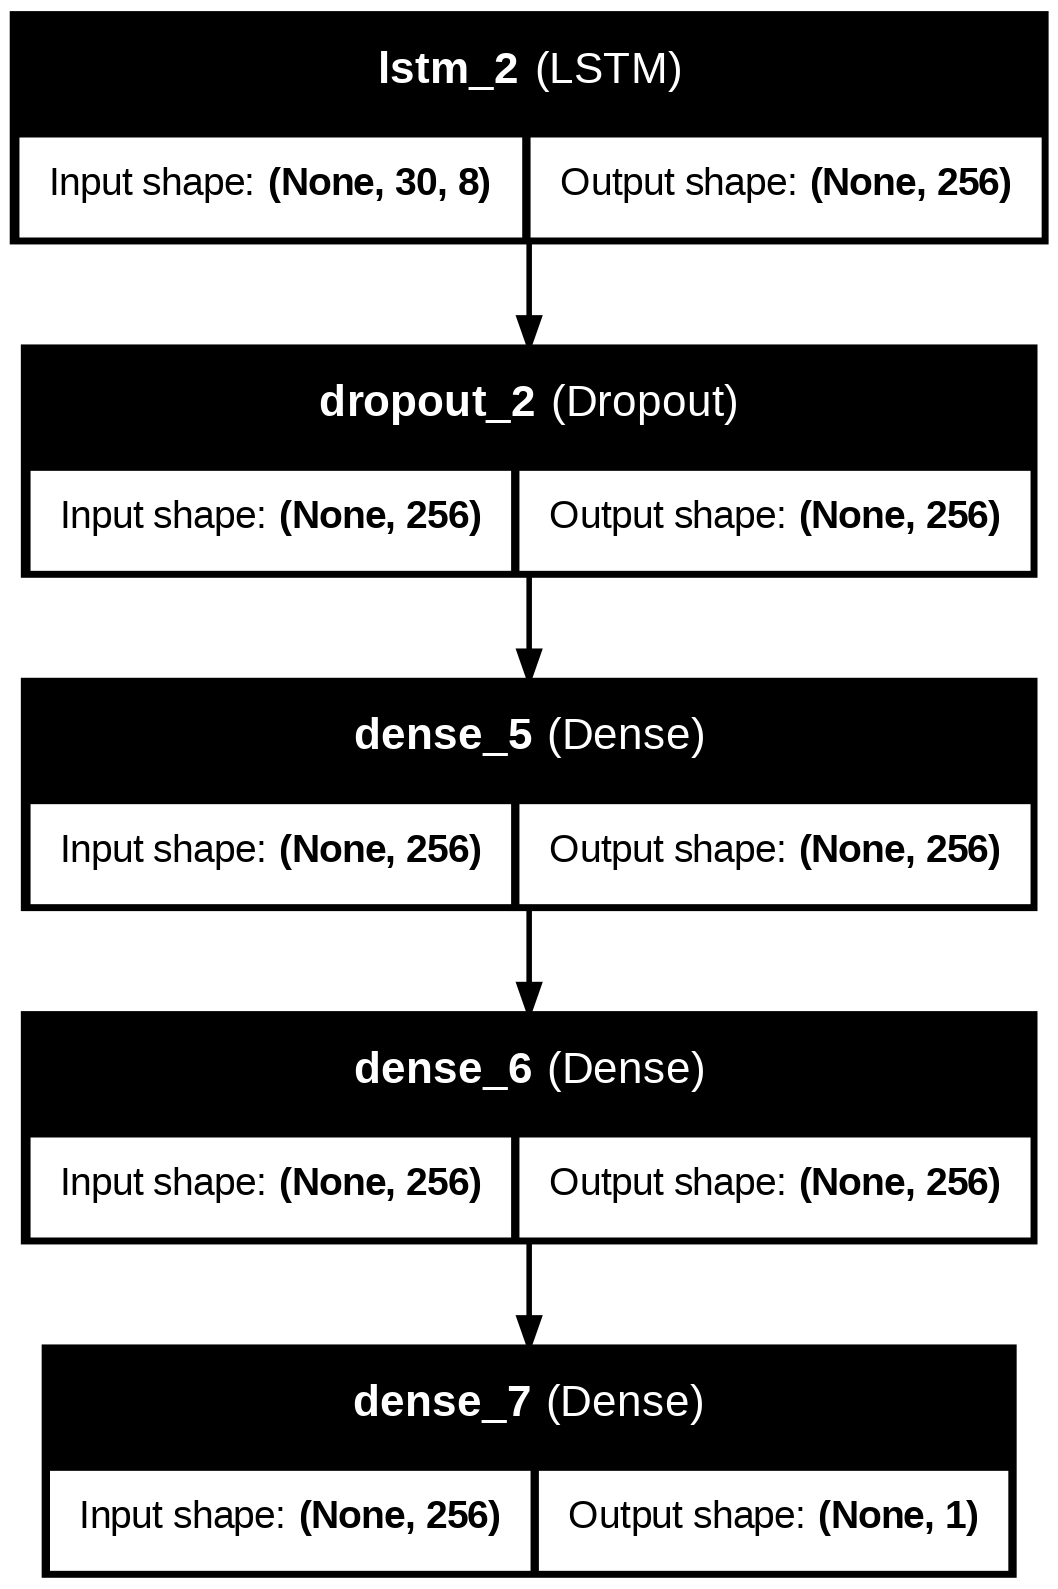

In [ ]:
# plot architecture of the best model
from keras.utils import plot_model

plot_model(best_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Evaluate the model
def evaluate_model(model, X, y):
    predictions = model.predict(X).flatten()
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = np.mean(np.abs((y_test1 - predictions) / y_test1)) * 100  # mean absolute percentage error
    return mse, mae, r2, mape

mse, mae, r2 ,mape= evaluate_model(best_model, X_test1, y_test1)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}% ,R²: {r2:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MSE: 0.0011, MAE: 0.0122, MAPE: 101.72% ,R²: 0.4642


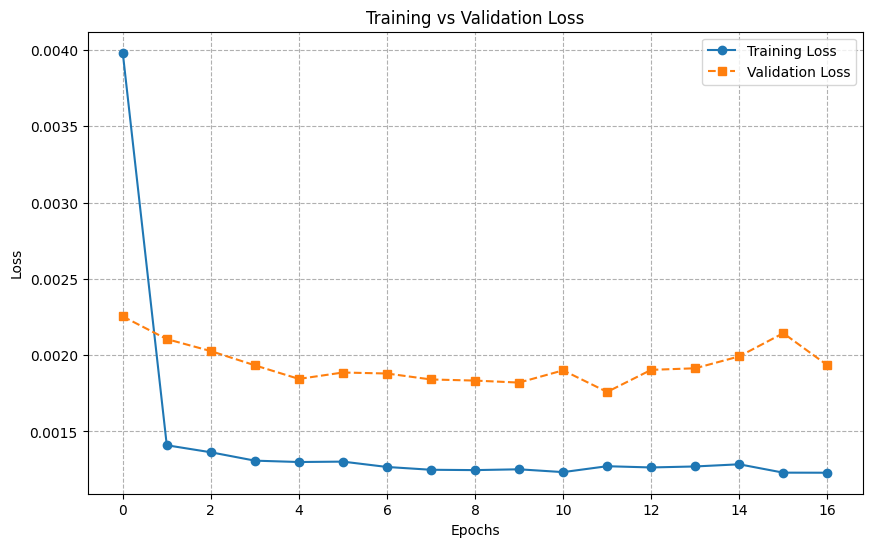

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(best_history['val_loss'], label='Validation Loss', linestyle='--', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


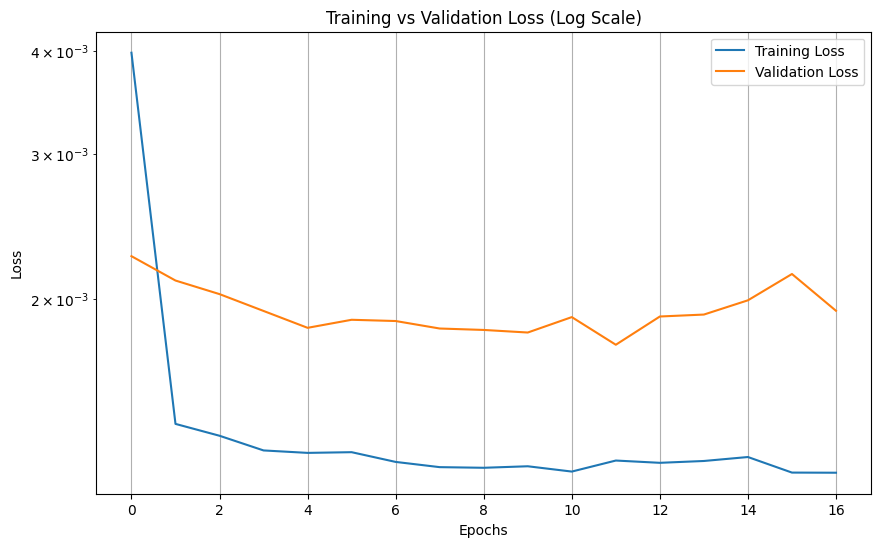

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Use log scale for better visualization
plt.title('Training vs Validation Loss (Log Scale)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Reverse normalization
def reverse_normalization(predictions, original_data, feature_index):
    max_value = original_data.iloc[:, feature_index].max()
    real_predictions = predictions * max_value
    return real_predictions

test_predictions = best_model.predict(X_test1).flatten()
real_predictions = reverse_normalization(test_predictions, df_original, feature_index=-1)
real_actuals = reverse_normalization(y_test1, df_original, feature_index=-1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


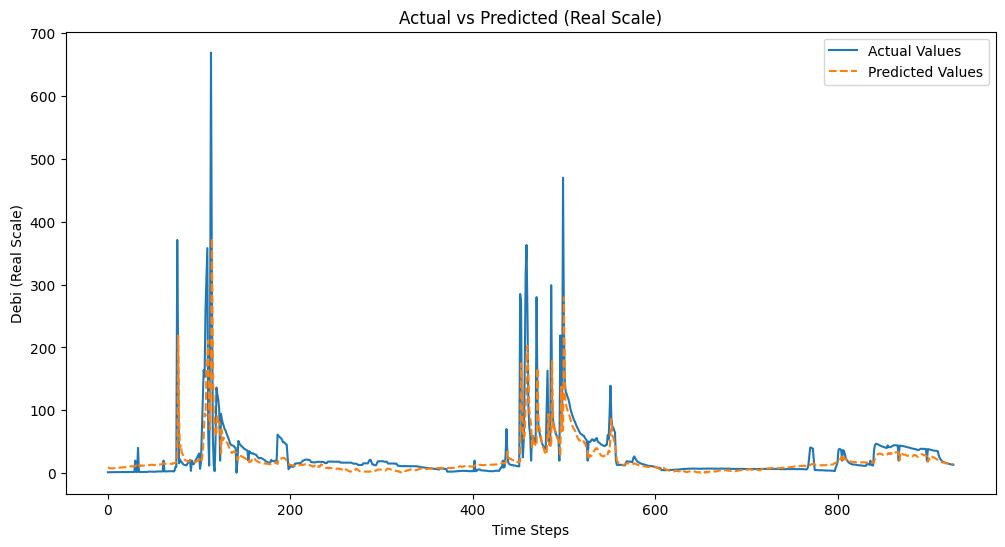

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_actuals, label='Actual Values')
plt.plot(real_predictions, label='Predicted Values', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Debi (Real Scale)')
plt.title('Actual vs Predicted (Real Scale)')
plt.legend()
plt.show()

In [ ]:
def reverse_normalization2(predictions, original_data, feature_index):

    max_value = original_data.iloc[:, feature_index].max()
    real_predictions = np.array(predictions) * max_value  # Convert to NumPy array before multiplication
    return real_predictions

In [ ]:
# Forecast future values
def forecast_future(model, initial_sequence, future_steps):
    future_predictions = []
    current_sequence = initial_sequence.copy()

    for _ in range(future_steps):
        next_value = model.predict(current_sequence)[0][0]
        future_predictions.append(next_value)
        current_sequence = np.roll(current_sequence, shift=-1, axis=1)
        current_sequence[0, -1, -1] = next_value  # Assuming the target is the last feature

    return future_predictions

future_steps = 30
initial_sequence = X_test1[-1:]
future_predictions = forecast_future(best_model, initial_sequence, future_steps)
future_predictions = reverse_normalization2(future_predictions, df_original, feature_index=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

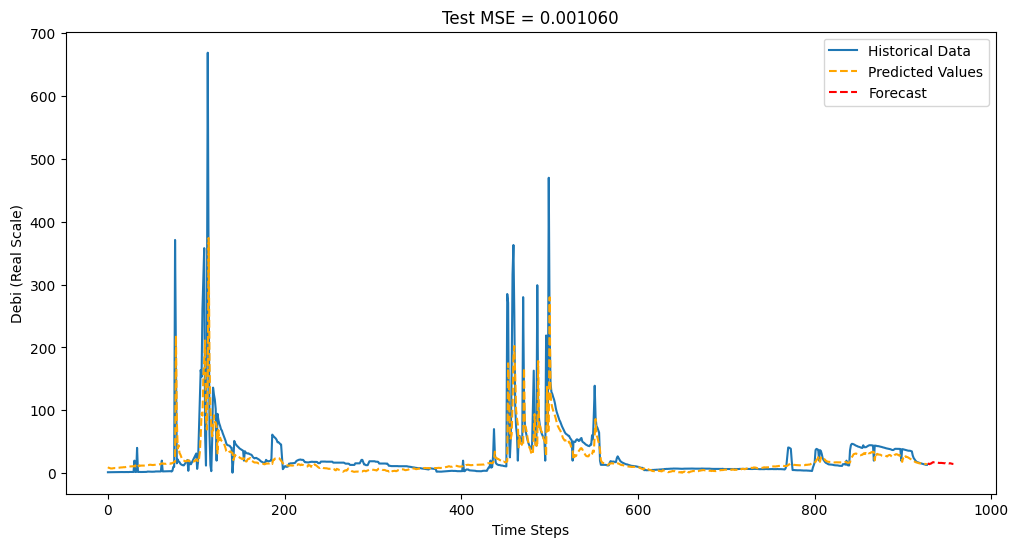

In [ ]:
# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(real_actuals)), real_actuals, label='Historical Data')
plt.plot(real_predictions, label='Predicted Values', linestyle='--', color='orange')
plt.plot(np.arange(len(real_actuals), len(real_actuals) + future_steps), future_predictions, label='Forecast', linestyle='--', color='r')
plt.xlabel('Time Steps')
plt.ylabel('Debi (Real Scale)')
plt.title(f'Test MSE = {mse:.6f}')
#plt.title('Actual vs Predicted (Real Scale) + Future Forecast ')
plt.legend()
plt.show()

In [ ]:
# another technique fr future forecasting to avoid compouniding errors:

def forecast_future(model, initial_sequence, future_steps, window_size=30):
    future_predictions = []
    current_sequence = initial_sequence.copy()

    for _ in range(future_steps):
        # Predict the next value based on the current sequence
        next_value = model.predict(current_sequence)[0][0]

        # Append the predicted value to the future predictions
        future_predictions.append(next_value)

        # Instead of rolling the sequence, keep the last window of original data
        current_sequence = np.roll(current_sequence, shift=-1, axis=1)
        current_sequence[0, -1, -1] = next_value  # Keep using the predicted value without adding to the sequence

    return future_predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

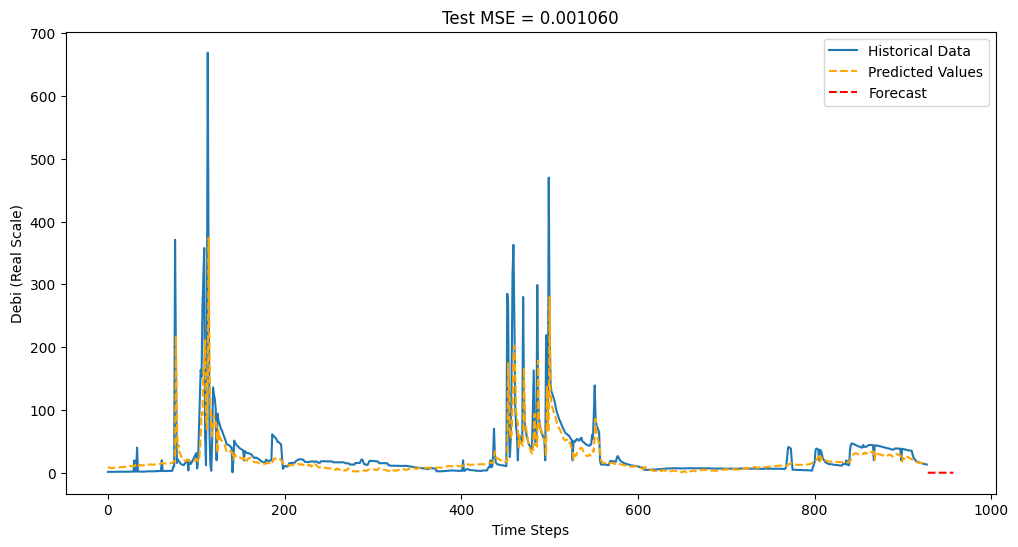

In [ ]:
# Forecast future steps
future_steps = 30
initial_sequence = X_test1[-1:]  # Last sequence in test data
future_predictions = forecast_future(best_model, initial_sequence, future_steps)

# Plotting future forecast
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(real_actuals)), real_actuals, label='Historical Data')
plt.plot(real_predictions, label='Predicted Values', linestyle='--', color='orange')
plt.plot(np.arange(len(real_actuals), len(real_actuals) + future_steps), future_predictions, label='Forecast', linestyle='--', color='r')
plt.xlabel('Time Steps')
plt.ylabel('Debi (Real Scale)')
plt.title(f'Test MSE = {mse:.6f}')
plt.legend()
plt.show()
